In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import json

import numpy as np
import mlflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.callbacks import EarlyStopping

from src.utils import (
    mlflow_credential_path,
    get_conv2d_metadata,
    mean_squared_error,
)

import matplotlib.pyplot as plt

2022-11-10 13:40:20.099478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## set environment variables

In [3]:
# read mlflow credentials
with open(mlflow_credential_path, "r") as f:
    credentials = json.load(f)

In [4]:
# set mlflow accounts
os.environ["MLFLOW_TRACKING_USERNAME"] = credentials["MLFLOW_TRACKING_USERNAME"]
os.environ["MLFLOW_TRACKING_PASSWORD"] = credentials["MLFLOW_TRACKING_PASSWORD"]

In [5]:
# set gpu
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## image data generator

In [6]:
class ImageGenerator:
    def __init__(self):
        pass
    
    @staticmethod
    def read_iamge(path: str):
        buffer = tf.io.read_file(path)
        image = tf.io.decode_jpeg(buffer)
        return image

    @staticmethod
    def resize_image(image: tf.Tensor, size: tuple):
        # force image shape to be squared (aspect_ratio)
        resized = tf.image.resize(
            image,
            size=size,
            method="bilinear",
            preserve_aspect_ratio=False
        )
        resized /= 255.
        return resized
    
    def get_dataset(self,
                    paths: list,
                    scores: list,
                    batch_size: int = 64,
                    image_shape: tuple = (224, 224),
                    num_parallel: int = tf.data.AUTOTUNE,
                    shuffle: bool = False):
        
        scores = tf.reshape(scores, (-1, 1))
        dataset = tf.data.Dataset.from_tensor_slices((paths, scores))
        
        # shuffle for trainig phase     
        if shuffle:
            buffer_size = len(paths)
            dataset = dataset.shuffle(buffer_size)
            
        # read & resize images
        dataset = dataset.map(
            lambda x, y: [self.read_iamge(x), tf.cast(y, "float32")],
            num_parallel_calls=num_parallel,
        )
        dataset = dataset.map(
            lambda x, y: [self.resize_image(x, image_shape), y],
            num_parallel_calls=num_parallel,
        )

        # to batch dataset
        dataset = dataset.batch(batch_size)
        
        return dataset

In [7]:
(X_train, y_train), (X_valid, y_valid) = get_conv2d_metadata()

In [8]:
image_gen = ImageGenerator()

In [9]:
train_dataset = image_gen.get_dataset(
    paths=X_train,
    scores=y_train,
    batch_size=64,
    image_shape=(224, 224),
    shuffle=True,
)

2022-11-10 13:27:24.238572: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-10 13:27:24.239095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-10 13:27:24.804945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 13:27:24.805041: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-10 13:27:24.805058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-10 13:27:24.806007: I tensorflow/stream_executor/platform/def

In [10]:
images, scores = next(iter(train_dataset))

2022-11-10 13:27:25.271949: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-10 13:27:25.289576: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


In [11]:
images.shape

TensorShape([64, 224, 224, 3])

In [12]:
scores.shape

TensorShape([64, 1])

Text(0.5, 0.75, 'Sample Images and Scores')

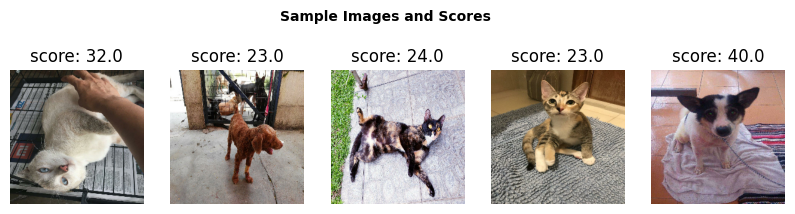

In [13]:
# draw sample images
num_draw = 5
fig, ax_arr = plt.subplots(1, num_draw, figsize=(10, 5))
for i in range(num_draw):
    ax = ax_arr[i]
    image = images[i]
    # max_val = tf.reduce_max(image, axis=(0, 1))
    # min_val = tf.reduce_min(image, axis=(0, 1))
    image = tf.cast(image*255, "uint8")
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"score: {tf.reshape(scores, (-1))[i]}")

fig.suptitle("Sample Images and Scores", weight="bold", size=10, y=0.75)

## conv regression

In [14]:
def get_keras_conv2d():
    """A function to build an instance of a Keras conv2d model."""
    inputs = Input(shape=(224, 224, 3))
    x = inputs
    
    x = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    
    x = Conv2D(filters=34, kernel_size=3, padding="same", activation="relu")(x)
    x = MaxPool2D(3)(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
    x = MaxPool2D(3)(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="linear", kernel_constraint=non_neg())(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [15]:
model = get_keras_conv2d()

In [16]:
train_dataset = image_gen.get_dataset(
    paths=X_train,
    scores=y_train,
    batch_size=64,
    image_shape=(224, 224),
    shuffle=True,
)

valid_dataset = image_gen.get_dataset(
    paths=X_valid,
    scores=y_valid,
    batch_size=64,
    image_shape=(224, 224),
    shuffle=False,
)

In [17]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        patience=5
    ),
]

In [18]:
# next(iter(train_dataset))[0]

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 34)      9826      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 34)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 34)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       39296 

In [20]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=callbacks,
)

Epoch 1/30


2022-11-10 13:27:26.077780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-10 13:27:26.220247: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-11-10 13:27:26.809898: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-10 13:27:26.837766: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


140/140 [==============================] - 15s 79ms/step - loss: 574.0721 - root_mean_squared_error: 23.8423 - val_loss: 596.3008 - val_root_mean_squared_error: 24.4193
Epoch 2/30
140/140 [==============================] - 7s 47ms/step - loss: 463.3879 - root_mean_squared_error: 21.5223 - val_loss: 534.8107 - val_root_mean_squared_error: 23.1260
Epoch 3/30
140/140 [==============================] - 7s 47ms/step - loss: 452.8241 - root_mean_squared_error: 21.2783 - val_loss: 493.0634 - val_root_mean_squared_error: 22.2050
Epoch 4/30
140/140 [==============================] - 7s 46ms/step - loss: 446.1761 - root_mean_squared_error: 21.1193 - val_loss: 471.0106 - val_root_mean_squared_error: 21.7028
Epoch 5/30
140/140 [==============================] - 7s 47ms/step - loss: 437.4661 - root_mean_squared_error: 20.9134 - val_loss: 456.9466 - val_root_mean_squared_error: 21.3763
Epoch 6/30
140/140 [==============================] - 7s 47ms/step - loss: 440.2201 - root_mean_squared_error: 20.9